Raw shape: (82, 14)
Columns: ['year_study_enc', 'gender_enc', 'age', 'cgpa', 'study_hours', 'courses', 'extra_activities_enc', 'extra_hours', 'job_enc', 'job_hours', 'stress_level', 'anxiety_level', 'sleep_hours', 'sleep_quality']
Auto-mapped columns: {'year_study_enc': 'year_of_study', 'gender_enc': 'gender', 'age': 'age', 'cgpa': 'cgpa', 'courses': 'courses_enrolled', 'job_enc': 'job', 'job_hours': 'job_hours_per_week', 'stress_level': 'stress_1to5', 'anxiety_level': 'anxiety_1to5', 'sleep_hours': 'sleep_hours', 'sleep_quality': 'sleep_quality_1to10'}
Cleaned shape: (82, 16)
Features created: ['sleep_deficit', 'sleep_squared']
Saved cleaned CSV to: /content/data/cleaned_survey_data.csv

--- Descriptive stats ---
                     count       mean        std    min    25%    50%     75%   max
age                   82.0  22.560976   1.228243  20.00  22.00  23.00  23.000  25.0
cgpa                  82.0   3.433922   0.465340   2.12   3.22   3.53   3.795   4.0
courses_enrolled      82

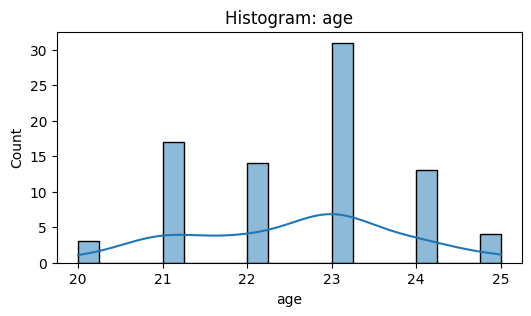

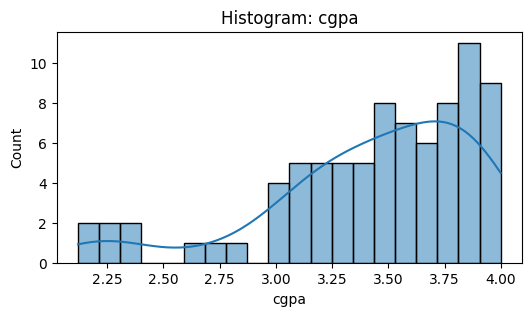

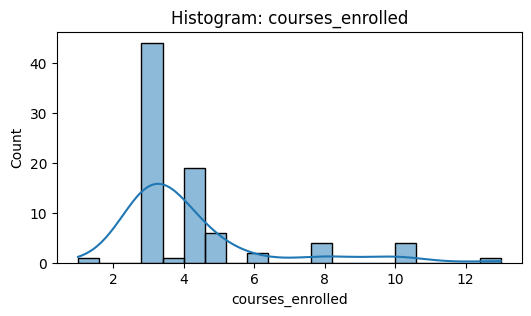

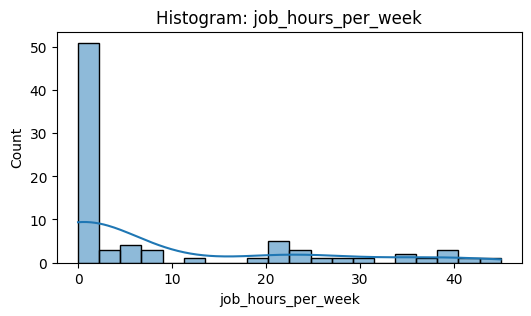

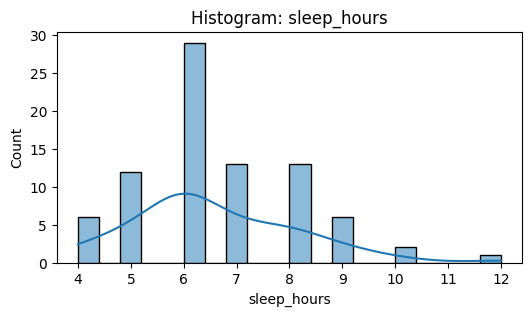

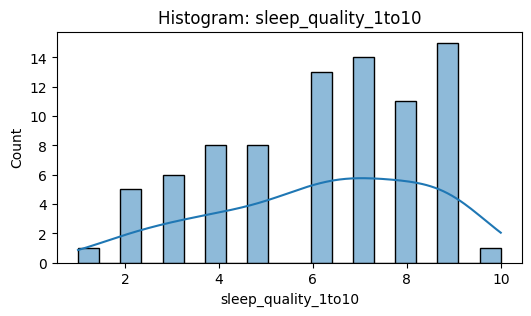

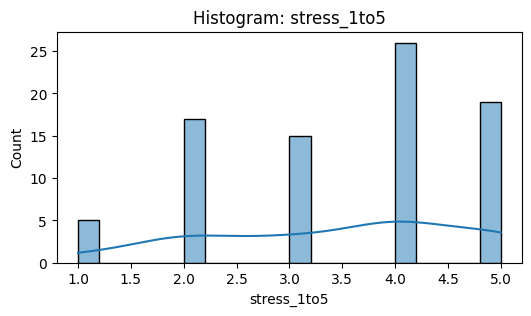

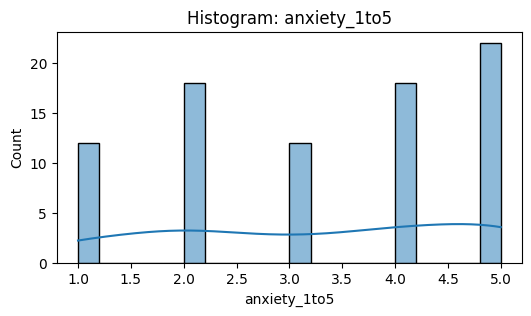

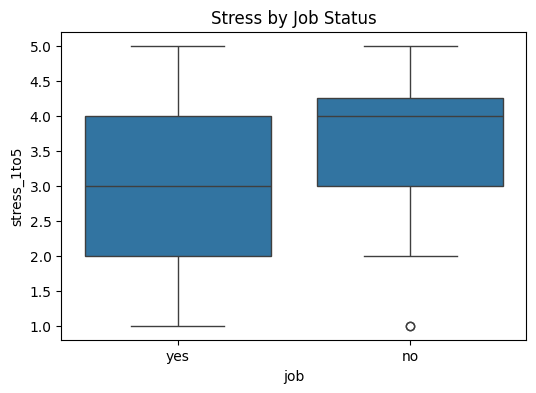

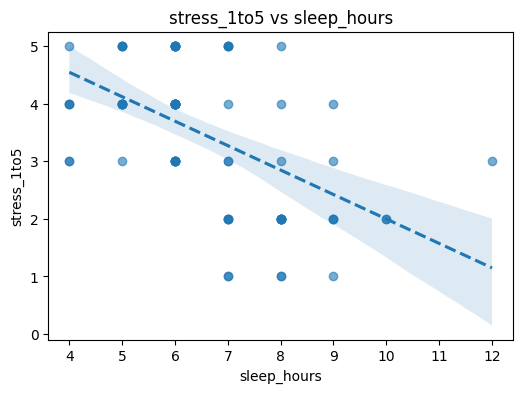

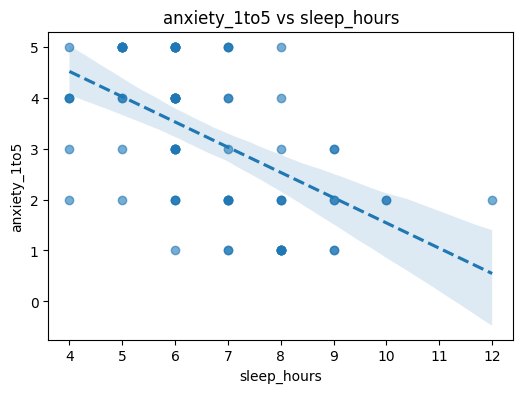

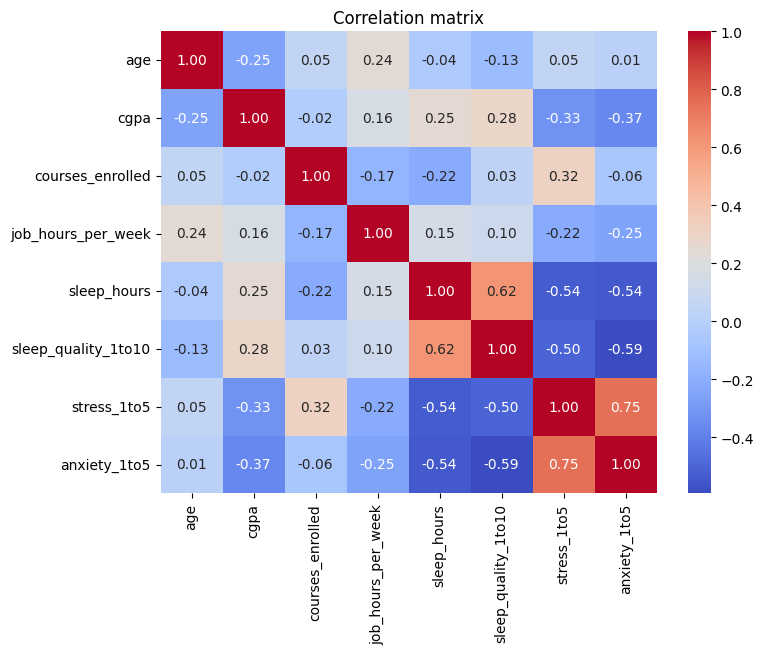


--- Hypothesis tests (alpha = 0.05) ---

Test: Stress by Job Status
H0: mean(stress | job=Yes) == mean(stress | job=No)
H1: they differ
Levene p (equal variances): 0.13337740563692382
t = -1.729 p = 0.0896
Cohen's d: -0.414
Result: Fail to reject H0 -> no evidence of difference
Shapiro p-values (Yes,No): 0.005798403665713563 9.083948661591602e-05
Normality suspicious: running Mann-Whitney U as nonparametric alternative.
Mann-Whitney U p = 0.09538570143312995

Test: Anxiety across year_of_study
H0: all year means equal; H1: at least one differs
Levene p: 0.9144214908388293
F = 0.546 p = 0.6522
eta-squared: 0.021
Fail to reject H0 -> no evidence of difference

Test: Proportion of high_stress by job status
z = -1.596 p = 0.1106

========== ADVANCED FEATURE SELECTION & MODELING ==========

Feature correlations with target (absolute):
sleep_hours            0.537334
sleep_squared          0.523150
sleep_quality_1to10    0.504373
low_sleep_quality      0.407799
courses_enrolled       0.3186

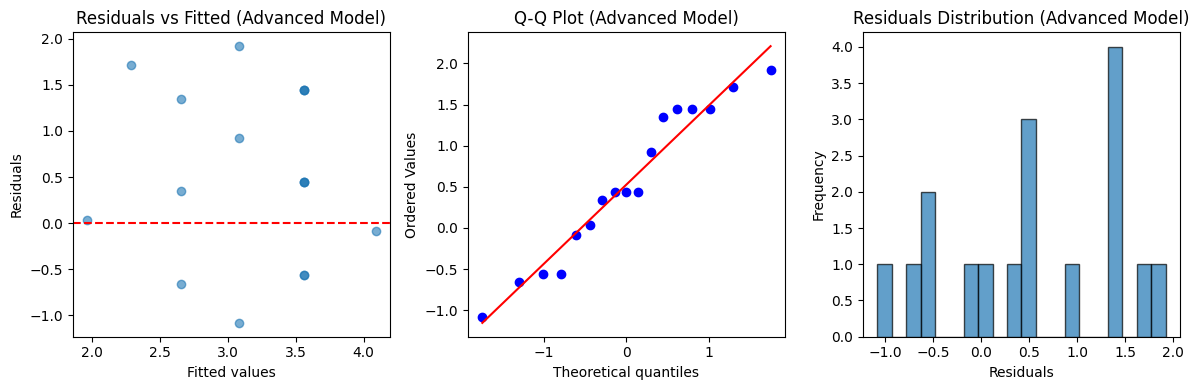


Trying multiple regression with predictors: ['courses_enrolled', 'job_hours_per_week', 'sleep_hours', 'sleep_quality_1to10']
                            OLS Regression Results                            
Dep. Variable:            stress_1to5   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     13.51
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.28e-07
Time:                        09:44:54   Log-Likelihood:                -73.897
No. Observations:                  57   AIC:                             157.8
Df Residuals:                      52   BIC:                             168.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.9

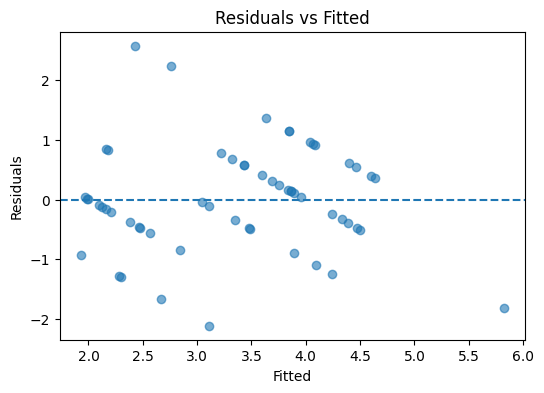

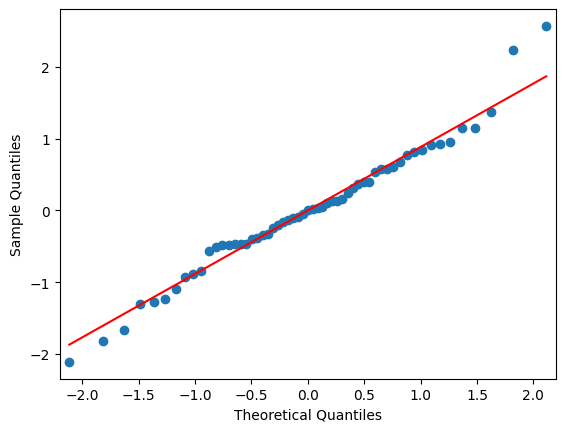

Breusch-Pagan LM p: 0.9350776293310367 F p: 0.9421001418414273

VIFs:
           variable       VIF
              const 28.427529
   courses_enrolled  1.129586
 job_hours_per_week  1.047132
        sleep_hours  1.801512
sleep_quality_1to10  1.714265

Test metrics: RMSE = 1.131, R2 = -0.086
CV R2 mean = 0.263 (std 0.332)

All done. Cleaned CSV saved to: /content/data/cleaned_survey_data.csv


In [6]:
import os
import re
import sys
import subprocess
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# ---------------- CONFIG ----------------
GOOGLE_DRIVE_LINK = "https://drive.google.com/file/d/14NusTm-yg5Wex-EJkF2DHwvGcxRmtZtU/view?usp=drive_link"
OUTPUT_FILENAME = "survey_responses.csv"
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
CSV_LOCAL_PATH = DATA_DIR / OUTPUT_FILENAME
CLEANED_PATH = DATA_DIR / "cleaned_survey_data.csv"

# ---------------- Utilities ----------------
def extract_drive_id(url: str):
    if not isinstance(url, str) or url.strip() == "":
        return None
    m = re.search(r"/d/([^/]+)", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([^&]+)", url)
    if m:
        return m.group(1)
    return None

def ensure_gdown_installed():
    try:
        import gdown  # noqa: F401
    except Exception:
        print("Installing gdown...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "gdown"], check=True)

def download_from_drive(file_id: str, out_path: Path):
    ensure_gdown_installed()
    import gdown
    url = f"https://drive.google.com/uc?id={file_id}"
    print("Downloading from:", url)
    gdown.download(url, str(out_path), quiet=False)
    if not out_path.exists():
        raise FileNotFoundError("Download failed. Make sure file is shared 'Anyone with the link'.")
    return out_path

def safe_read_csv(path: Path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, encoding="latin1", low_memory=False)

# ---------------- Cleaning ----------------
def clean_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    rename_map = {}
    for col in df.columns:
        low = col.lower().strip()
        if 'year' in low and 'study' in low:
            rename_map[col] = 'year_of_study'
        elif low.startswith('gender'):
            rename_map[col] = 'gender'
        elif low == 'age' or ('age' in low and 'your' in low):
            rename_map[col] = 'age'
        elif 'cgpa' in low:
            rename_map[col] = 'cgpa'
        elif 'study' in low and ('week' in low or 'per' in low):
            rename_map[col] = 'study_hours_per_week'
        elif 'course' in low and any(k in low for k in ('enroll','credit','courses','course')):
            rename_map[col] = 'courses_enrolled'
        elif 'extracurricular' in low or ('extra' in low and 'activity' in low):
            if 'hour' in low or 'per' in low:
                rename_map[col] = 'extra_hours_per_week'
            else:
                rename_map[col] = 'extracurricular'
        elif 'job' in low and 'hour' in low:
            rename_map[col] = 'job_hours_per_week'
        elif 'job' in low:
            rename_map[col] = 'job'
        elif 'stress' in low:
            rename_map[col] = 'stress_1to5'
        elif 'anxiety' in low:
            rename_map[col] = 'anxiety_1to5'
        elif 'sleep' in low and 'quality' in low:
            rename_map[col] = 'sleep_quality_1to10'
        elif 'sleep' in low and 'hour' in low:
            rename_map[col] = 'sleep_hours'
        elif 'timestamp' in low or low == 'time':
            rename_map[col] = 'timestamp'
    if rename_map:
        print("Auto-mapped columns:", rename_map)
    df = df.rename(columns=rename_map)

    # Trim strings
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip()

    # Numeric coercion (robust)
    def to_numeric_col(s):
        try:
            return pd.to_numeric(s, errors='coerce')
        except Exception:
            return s.astype(str).str.replace(',', '').str.extract(r'([-+]?\d*\.?\d+)')[0].astype(float)

    numeric_cols = ['age','cgpa','study_hours_per_week','courses_enrolled','extra_hours_per_week',
                    'job_hours_per_week','sleep_hours','sleep_quality_1to10','stress_1to5','anxiety_1to5']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = to_numeric_col(df[c])

    # Normalize yes/no
    def norm_yesno(series):
        s = series.astype(str).str.strip().str.lower().replace({'nan': None})
        s = s.replace({'yes.':'yes','yes':'yes','y':'yes','true':'yes','1':'yes',
                       'no.':'no','no':'no','n':'no','false':'no','0':'no'})
        return s

    if 'extracurricular' in df.columns:
        df['extracurricular'] = norm_yesno(df['extracurricular'])
        df['extracurricular_bin'] = (df['extracurricular'] == 'yes').astype(int)
    else:
        if 'extra_hours_per_week' in df.columns:
            df['extracurricular_bin'] = (df['extra_hours_per_week'].fillna(0) > 0).astype(int)

    if 'job' in df.columns:
        df['job'] = norm_yesno(df['job'])
        df['job_bin'] = (df['job'] == 'yes').astype(int)
    else:
        if 'job_hours_per_week' in df.columns:
            df['job_bin'] = (df['job_hours_per_week'].fillna(0) > 0).astype(int)

    if 'job' in df.columns and 'job_hours_per_week' in df.columns:
        df.loc[df['job']=='no', 'job_hours_per_week'] = df.loc[df['job']=='no', 'job_hours_per_week'].fillna(0)
    if 'extracurricular' in df.columns and 'extra_hours_per_week' in df.columns:
        df.loc[df['extracurricular']=='no', 'extra_hours_per_week'] = df.loc[df['extracurricular']=='no', 'extra_hours_per_week'].fillna(0)

    if 'year_of_study' in df.columns:
        df['year_of_study'] = pd.to_numeric(df['year_of_study'], errors='coerce').astype('Int64')

    if 'stress_1to5' in df.columns:
        df['high_stress'] = (df['stress_1to5'] >= 4).astype(int)

    df = df.loc[:, df.notna().any()]
    df = df.reset_index(drop=True)
    return df

# ============ FEATURE ENGINEERING FOR BETTER R² ============
def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create interaction and polynomial features to improve model fit"""
    df = df.copy()

    # Interaction terms for stress
    if 'study_hours_per_week' in df.columns and 'sleep_hours' in df.columns:
        df['study_sleep_interaction'] = df['study_hours_per_week'] * df['sleep_hours']

    if 'job_hours_per_week' in df.columns and 'study_hours_per_week' in df.columns:
        df['job_study_interaction'] = df['job_hours_per_week'] * df['study_hours_per_week']

    # Sleep deficit indicator
    if 'sleep_hours' in df.columns:
        df['sleep_deficit'] = (df['sleep_hours'] < 6).astype(int)
        df['sleep_squared'] = df['sleep_hours'] ** 2

    # Total workload
    workload_cols = ['study_hours_per_week', 'job_hours_per_week', 'extra_hours_per_week']
    available_workload = [c for c in workload_cols if c in df.columns]
    if len(available_workload) >= 2:
        df['total_workload'] = df[available_workload].sum(axis=1)

    # Low sleep quality indicator
    if 'sleep_quality_1to10' in df.columns:
        df['low_sleep_quality'] = (df['sleep_quality_1to10'] < 6).astype(int)

    return df

# ============ FEATURE SELECTION FOR BETTER R² ============
def select_best_predictors(df: pd.DataFrame, target: str, candidate_predictors: list, max_features: int = 8) -> list:
    """Use correlation to select best predictors and remove multicollinearity"""
    df_clean = df[[target] + candidate_predictors].dropna()

    if df_clean.shape[0] < 10:
        print("Warning: Not enough data for feature selection")
        return candidate_predictors

    # Calculate correlations with target
    correlations = df_clean[candidate_predictors].corrwith(df_clean[target]).abs().sort_values(ascending=False)
    print("\nFeature correlations with target (absolute):")
    print(correlations)

    # Start with most correlated features
    selected = []
    for feat in correlations.index:
        if len(selected) >= max_features:
            break
        # Check VIF if adding this feature
        test_features = selected + [feat]
        if len(test_features) <= 2:
            selected.append(feat)
        else:
            test_df = df_clean[test_features].fillna(0)
            test_x = sm.add_constant(test_df)
            vifs = [variance_inflation_factor(test_x.values, i) for i in range(test_x.shape[1])]
            if max(vifs[1:]) < 5:  # Exclude constant
                selected.append(feat)

    print(f"\nSelected {len(selected)} features: {selected}")
    return selected

# ============ ADVANCED MODELING WITH MULTIPLE ALGORITHMS ============
def fit_models_with_eval_advanced(df: pd.DataFrame, target: str, predictors: list):
    """Fit multiple models with hyperparameter tuning for better R²"""
    df2 = df[[target] + predictors].dropna()
    if df2.shape[0] < (len(predictors) + 3):
        raise ValueError("Not enough rows for regression with these predictors.")

    X = df2[predictors].values
    y = df2[target].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

    # OLS Model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_ols = lr.predict(X_test_scaled)
    results['OLS'] = {
        'model': lr,
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_ols)),
        'test_r2': r2_score(y_test, y_pred_ols),
        'test_mae': mean_absolute_error(y_test, y_pred_ols),
        'y_pred': y_pred_ols
    }

    # Ridge Regression (with grid search)
    ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    ridge = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
    ridge.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge.predict(X_test_scaled)
    results['Ridge'] = {
        'model': ridge.best_estimator_,
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        'test_r2': r2_score(y_test, y_pred_ridge),
        'test_mae': mean_absolute_error(y_test, y_pred_ridge),
        'best_alpha': ridge.best_params_['alpha'],
        'y_pred': y_pred_ridge
    }

    # Lasso Regression (with grid search)
    lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    lasso = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='r2')
    lasso.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso.predict(X_test_scaled)
    results['Lasso'] = {
        'model': lasso.best_estimator_,
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        'test_r2': r2_score(y_test, y_pred_lasso),
        'test_mae': mean_absolute_error(y_test, y_pred_lasso),
        'best_alpha': lasso.best_params_['alpha'],
        'y_pred': y_pred_lasso
    }

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(LinearRegression(), X, y, scoring='r2', cv=cv)

    return {
        'models': results,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'y_pred_ols': y_pred_ols,
        'cv_scores': cv_scores,
        'scaler': scaler,
        'predictors': predictors
    }

# ============ ORIGINAL TEST FUNCTIONS ============
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    sa, sb = np.std(a, ddof=1), np.std(b, ddof=1)
    s_pool = np.sqrt(((na-1)*sa*sa + (nb-1)*sb*sb) / (na+nb-2)) if (na+nb-2)>0 else np.nan
    return (a.mean() - b.mean()) / s_pool if s_pool != 0 else np.nan

def eta_squared(groups, overall_series):
    ss_between = sum([len(g) * (g.mean() - overall_series.mean())**2 for g in groups])
    ss_total = ((overall_series - overall_series.mean())**2).sum()
    return ss_between / ss_total if ss_total > 0 else np.nan

def run_tests_and_print(df):
    alpha = 0.05
    print("\n--- Hypothesis tests (alpha = 0.05) ---")
    # 1) Stress by job
    if {'job','stress_1to5'}.issubset(df.columns):
        print("\nTest: Stress by Job Status")
        print("H0: mean(stress | job=Yes) == mean(stress | job=No)")
        print("H1: they differ")
        grp_yes = df.loc[df['job']=='yes','stress_1to5'].dropna()
        grp_no = df.loc[df['job']=='no','stress_1to5'].dropna()
        if len(grp_yes)>1 and len(grp_no)>1:
            lev_p = stats.levene(grp_yes, grp_no).pvalue
            print("Levene p (equal variances):", lev_p)
            t_stat, p = stats.ttest_ind(grp_yes, grp_no, equal_var=False)
            print("t =", round(t_stat,3), "p =", round(p,4))
            print("Cohen's d:", round(cohens_d(grp_yes, grp_no),3))
            if p < alpha:
                print("Result: Reject H0 -> groups differ")
            else:
                print("Result: Fail to reject H0 -> no evidence of difference")
            # normality check
            if len(grp_yes) <= 5000:
                p_sh_y = stats.shapiro(grp_yes).pvalue if len(grp_yes)>=3 else None
                p_sh_n = stats.shapiro(grp_no).pvalue if len(grp_no)>=3 else None
                print("Shapiro p-values (Yes,No):", p_sh_y, p_sh_n)
                if (p_sh_y is not None and p_sh_y < alpha) or (p_sh_n is not None and p_sh_n < alpha):
                    print("Normality suspicious: running Mann-Whitney U as nonparametric alternative.")
                    mw = stats.mannwhitneyu(grp_yes, grp_no, alternative='two-sided')
                    print("Mann-Whitney U p =", mw.pvalue)
        else:
            print("Insufficient data for t-test.")

    # 2) ANOVA: anxiety across years
    if {'year_of_study','anxiety_1to5'}.issubset(df.columns):
        print("\nTest: Anxiety across year_of_study")
        print("H0: all year means equal; H1: at least one differs")
        groups = [df.loc[df['year_of_study']==k,'anxiety_1to5'].dropna() for k in sorted(df['year_of_study'].dropna().unique())]
        groups = [g for g in groups if len(g)>1]
        if len(groups) >= 2:
            lev_p = stats.levene(*groups).pvalue
            print("Levene p:", lev_p)
            F, p = stats.f_oneway(*groups)
            print("F =", round(F,3), "p =", round(p,4))
            print("eta-squared:", round(eta_squared(groups, df['anxiety_1to5']),3))
            if p < alpha:
                print("Reject H0 -> at least one mean differs")
            else:
                print("Fail to reject H0 -> no evidence of difference")
        else:
            print("Insufficient group sizes for ANOVA.")

    # 3) Correlation: study_hours vs stress
    if {'study_hours_per_week','stress_1to5'}.issubset(df.columns):
        print("\nTest: Correlation study_hours_per_week vs stress_1to5")
        v = df[['study_hours_per_week','stress_1to5']].dropna()
        if len(v) >= 3:
            r, p = stats.pearsonr(v['study_hours_per_week'], v['stress_1to5'])
            sr, sp = stats.spearmanr(v['study_hours_per_week'], v['stress_1to5'])
            print("Pearson r =", round(r,3), "p =", round(p,4))
            print("Spearman rho =", round(sr,3), "p =", round(sp,4))
        else:
            print("Insufficient observations for correlation test.")

    # 4) Proportion test: high_stress by job
    if {'job','high_stress'}.issubset(df.columns):
        print("\nTest: Proportion of high_stress by job status")
        grp1 = df.loc[df['job']=='yes','high_stress'].dropna().astype(int)
        grp2 = df.loc[df['job']=='no','high_stress'].dropna().astype(int)
        if len(grp1)>0 and len(grp2)>0:
            from statsmodels.stats.proportion import proportions_ztest
            count = np.array([grp1.sum(), grp2.sum()])
            nobs = np.array([len(grp1), len(grp2)])
            z, p = proportions_ztest(count, nobs)
            print("z =", round(z,3), "p =", round(p,4))
        else:
            print("Insufficient data for proportion test.")

# ============ ORIGINAL VIF FUNCTION ============
def compute_vif_df(X_df: pd.DataFrame):
    Xc = sm.add_constant(X_df.fillna(0))
    vif_list = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    return pd.DataFrame({'variable': Xc.columns, 'VIF': vif_list})

# ============ ORIGINAL SIMPLE REGRESSION ============
def fit_models_with_eval(df, target, predictors):
    df2 = df[[target] + predictors].dropna()
    if df2.shape[0] < (len(predictors) + 3):
        raise ValueError("Not enough rows for regression with these predictors.")
    X = df2[predictors]
    y = df2[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_df = pd.concat([y_train, X_train], axis=1)
    formula = f"{target} ~ " + " + ".join(predictors)
    model = smf.ols(formula=formula, data=train_df).fit()
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    # CV with sklearn
    lr = LinearRegression()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(lr, X, y, scoring='r2', cv=cv)
    robust = model.get_robustcov_results(cov_type='HC3')
    return {
        'model': model, 'robust': robust,
        'test_rmse': rmse, 'test_r2': r2,
        'cv_r2_mean': float(np.nanmean(cv_scores)), 'cv_r2_std': float(np.nanstd(cv_scores))
    }

# ============ MAIN ============
def main():
    # If CSV missing, optionally ask user to upload manually in Colab. Here we attempt Drive download.
    drive_id = extract_drive_id(GOOGLE_DRIVE_LINK)
    if drive_id and not CSV_LOCAL_PATH.exists():
        download_from_drive(drive_id, CSV_LOCAL_PATH)
    if not CSV_LOCAL_PATH.exists():
        raise FileNotFoundError(f"CSV not found at {CSV_LOCAL_PATH}. Upload to /content/data or update GOOGLE_DRIVE_LINK.")
    raw = safe_read_csv(CSV_LOCAL_PATH)
    print("Raw shape:", raw.shape)
    print("Columns:", list(raw.columns)[:50])

    cleaned = clean_transform(raw)
    print("Cleaned shape:", cleaned.shape)

    # ========== CREATE ADVANCED FEATURES ==========
    cleaned = create_advanced_features(cleaned)
    print("Features created:", [c for c in cleaned.columns if 'interaction' in c or 'workload' in c or 'deficit' in c or 'squared' in c])

    cleaned.to_csv(CLEANED_PATH, index=False)
    print("Saved cleaned CSV to:", CLEANED_PATH)

    # EDA
    numeric_cols = [c for c in ['age','cgpa','study_hours_per_week','courses_enrolled','extra_hours_per_week',
                                'job_hours_per_week','sleep_hours','sleep_quality_1to10','stress_1to5','anxiety_1to5'] if c in cleaned.columns]
    if numeric_cols:
        print("\n--- Descriptive stats ---")
        print(cleaned[numeric_cols].describe().T.to_string())

    # histograms
    for col in numeric_cols:
        plt.figure(figsize=(6,3))
        sns.histplot(cleaned[col].dropna(), bins=20, kde=True)
        plt.title(f"Histogram: {col}")
        plt.show()

    # Boxplots & scatterplots
    if {'job','stress_1to5'}.issubset(cleaned.columns):
        plt.figure(figsize=(6,4))
        sns.boxplot(data=cleaned, x='job', y='stress_1to5')
        plt.title("Stress by Job Status")
        plt.show()
    pairs = [('study_hours_per_week','stress_1to5'), ('sleep_hours','stress_1to5'), ('sleep_hours','anxiety_1to5')]
    for xcol,ycol in pairs:
        if xcol in cleaned.columns and ycol in cleaned.columns:
            v = cleaned[[xcol,ycol]].dropna()
            if len(v) >= 3:
                plt.figure(figsize=(6,4))
                sns.regplot(x=xcol, y=ycol, data=v, scatter_kws={'alpha':0.6}, line_kws={'linestyle':'--'})
                plt.title(f"{ycol} vs {xcol}")
                plt.show()

    if len(numeric_cols) >= 2:
        corr = cleaned[numeric_cols].corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation matrix")
        plt.show()

    # Hypothesis tests
    run_tests_and_print(cleaned)

    # Simple regression
    if {'stress_1to5','study_hours_per_week'}.issubset(cleaned.columns):
        df_simp = cleaned[['stress_1to5','study_hours_per_week']].dropna()
        if len(df_simp) >= 10:
            print("\nSimple regression: stress ~ study_hours_per_week")
            model_simple = smf.ols('stress_1to5 ~ study_hours_per_week', data=df_simp).fit()
            print(model_simple.summary())
            print("Durbin-Watson:", sm.stats.stattools.durbin_watson(model_simple.resid))
            try:
                w, p_sh = stats.shapiro(model_simple.resid) if len(model_simple.resid) <= 5000 else (None, None)
                print("Shapiro on residuals p:", p_sh)
            except Exception:
                pass
            print("Confidence intervals:\n", model_simple.conf_int())
        else:
            print("Not enough observations for reliable simple regression (recommended >=10).")

    # ========== ADVANCED MULTIPLE REGRESSION WITH BETTER R² ==========
    possible_predictors = ['study_hours_per_week','courses_enrolled','job_hours_per_week','sleep_hours','sleep_quality_1to10',
                          'extracurricular_bin','study_sleep_interaction','job_study_interaction','sleep_deficit','sleep_squared','total_workload','low_sleep_quality']
    predictors = [p for p in possible_predictors if p in cleaned.columns]
    target = 'stress_1to5'

    if target in cleaned.columns and predictors:
        print("\n========== ADVANCED FEATURE SELECTION & MODELING ==========")
        candidate_pred = [p for p in predictors if p in cleaned.columns]
        selected_preds = select_best_predictors(cleaned, target, candidate_pred, max_features=8)

        df_multi = cleaned[[target] + selected_preds].dropna()
        print(f"Data shape for advanced modeling: {df_multi.shape}")

        if df_multi.shape[0] > (len(selected_preds) + 2):
            try:
                adv_results = fit_models_with_eval_advanced(cleaned, target, selected_preds)

                print("\n========== ADVANCED MODEL COMPARISON ==========")
                for model_name, metrics in adv_results['models'].items():
                    print(f"\n{model_name}:")
                    print(f"  Test R²: {metrics['test_r2']:.4f}")
                    print(f"  Test RMSE: {metrics['test_rmse']:.4f}")
                    print(f"  Test MAE: {metrics['test_mae']:.4f}")
                    if 'best_alpha' in metrics:
                        print(f"  Best Alpha: {metrics['best_alpha']}")

                print(f"\nCross-validation R² (mean ± std): {adv_results['cv_scores'].mean():.4f} ± {adv_results['cv_scores'].std():.4f}")

                # Advanced diagnostics
                residuals = adv_results['y_test'] - adv_results['y_pred_ols']

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.scatter(adv_results['y_pred_ols'], residuals, alpha=0.6)
                plt.axhline(0, linestyle='--', color='red')
                plt.xlabel("Fitted values")
                plt.ylabel("Residuals")
                plt.title("Residuals vs Fitted (Advanced Model)")

                plt.subplot(1, 3, 2)
                stats.probplot(residuals, dist="norm", plot=plt)
                plt.title("Q-Q Plot (Advanced Model)")

                plt.subplot(1, 3, 3)
                plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
                plt.xlabel("Residuals")
                plt.ylabel("Frequency")
                plt.title("Residuals Distribution (Advanced Model)")
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print("Advanced modeling failed:", e)
                import traceback
                traceback.print_exc()

    # Multiple regression (original)
    possible_predictors = ['study_hours_per_week','courses_enrolled','job_hours_per_week','sleep_hours','sleep_quality_1to10','extracurricular_bin']
    predictors = [p for p in possible_predictors if p in cleaned.columns]
    target = 'stress_1to5'
    if target in cleaned.columns and predictors:
        df_multi = cleaned[[target] + predictors].dropna()
        print("\nTrying multiple regression with predictors:", predictors)
        if df_multi.shape[0] > (len(predictors) + 2):
            try:
                results = fit_models_with_eval(cleaned, target, predictors)
                print(results['model'].summary())
                print("\nRobust SE (HC3):")
                print(results['robust'].summary())
                # Diagnostics
                resid = results['model'].resid
                fitted = results['model'].fittedvalues
                plt.figure(figsize=(6,4))
                plt.scatter(fitted, resid, alpha=0.6)
                plt.axhline(0, linestyle='--')
                plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted")
                plt.show()
                fig_qq = sm.qqplot(resid, line='s').get_figure()
                plt.show()
                # Breusch-Pagan
                try:
                    from statsmodels.stats.diagnostic import het_breuschpagan
                    lm, lm_p, fval, f_p = het_breuschpagan(resid, results['model'].model.exog)
                    print("Breusch-Pagan LM p:", lm_p, "F p:", f_p)
                except Exception as e:
                    print("Breusch-Pagan could not be run:", e)
                # VIF
                X_for_vif = df_multi[predictors].dropna()
                print("\nVIFs:")
                print(compute_vif_df(X_for_vif).to_string(index=False))
                print("\nTest metrics: RMSE = {:.3f}, R2 = {:.3f}".format(results['test_rmse'], results['test_r2']))
                print("CV R2 mean = {:.3f} (std {:.3f})".format(results['cv_r2_mean'], results['cv_r2_std']))
            except Exception as e:
                print("Multiple regression failed:", e)
        else:
            print("Not enough rows for multiple regression (need rows > num_predictors+2).")

    print("\nAll done. Cleaned CSV saved to:", CLEANED_PATH)

if __name__ == "__main__":
    main()